In [18]:
import os
import math
import numpy as np

import matplotlib.pyplot as plt
import mplcyberpunk

from sklearn.svm import SVC

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

In [19]:
TRAIN_DIR = "C:/data/Pizza vs Icecream/train"
VAL_DIR = "C:/data/Pizza vs Icecream/valid"
TEST_DIR = "C:/data/Pizza vs Icecream/test"

In [20]:
BATCH_SIZE=32
IMG_SIZE = 480

In [21]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 718 images belonging to 2 classes.


In [22]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 208 images belonging to 2 classes.


In [23]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 106 images belonging to 2 classes.


In [24]:
def plot_grid_images(images, labels, columns=5, image_size=None, figsize=(8, 8), cmap='gray', title=None, file_name=None):
    fig = plt.figure(figsize=figsize)
    fig.tight_layout(h_pad=3)
    rows = math.ceil(len(images)/columns)
    for image, label, position in zip(images, labels, range(1, len(labels)+1)):
        fig.add_subplot(rows, columns, position)
        if image_size is not None:
            image = image.reshape(image_size)

        plt.imshow(image, cmap=cmap, interpolation='nearest')
        plt.axis('off')
        plt.title(label)
    if title is not None:
        fig.suptitle(title, fontsize=14)

    if file_name is not None:
        plt.savefig(file_name)
    plt.show()
    return file_name


def show_examples(generator, no_labels=False, title=None, no_images_to_show=9, columns=3):
    images_to_show = []
    images_labels = []
    images_shape = None
    
    if no_labels:
        for images in generator:
            images_shape = images.shape[1:]
            images_to_show.extend(images)
            if len(images_to_show) >= no_images_to_show:
                break
        images_labels = [None for _ in range(no_images_to_show)]
    else:
        class_indices = {index: label for label, index in generator.class_indices.items()}
        for images, labels in generator:
            images_shape = images.shape[1:]
            images_to_show.extend(images)
            images_labels.extend([class_indices[index] for index in labels])
            if len(images_to_show) >= no_images_to_show:
                break
    
    print('IMAGE SHAPE: ', images_shape)
    plot_grid_images(images_to_show[:no_images_to_show], images_labels[:no_images_to_show], title=title, columns=columns)

IMAGE SHAPE:  (480, 480, 3)


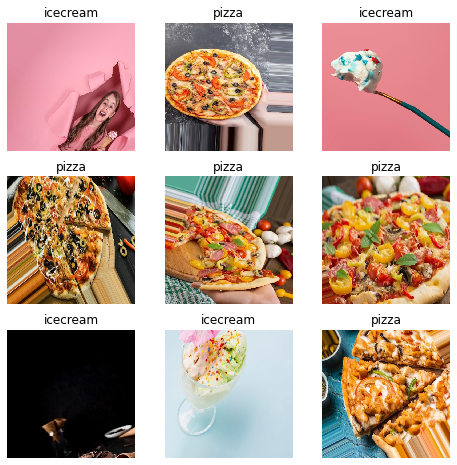

In [25]:
show_examples(train_generator)

IMAGE SHAPE:  (480, 480, 3)


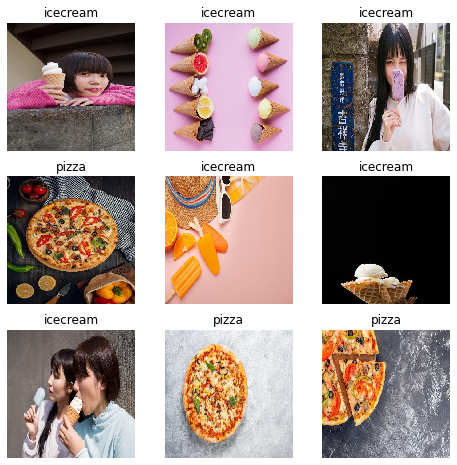

In [26]:
show_examples(val_generator)

IMAGE SHAPE:  (480, 480, 3)


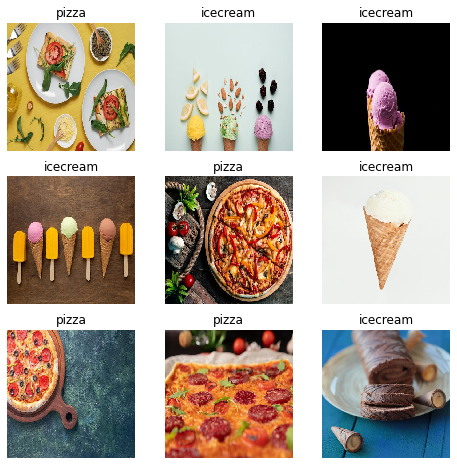

In [27]:
show_examples(test_generator)

In [28]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 480, 480, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 240, 240, 16)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 240, 240, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 240, 240, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 120, 120, 32)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 120, 120, 32)     

In [30]:
SAVED_MODEL_PATH = 'C:/data/Pizza vs Icecream/pizza_vs_icecream_model.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    SAVED_MODEL_PATH,
    monitor='val_loss',
    save_best_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/50
23/23 [==============================] - 214s 9s/step - loss: 4.2053 - accuracy: 0.5905 - val_loss: 0.6836 - val_accuracy: 0.6442
Epoch 2/50
23/23 [==============================] - 200s 9s/step - loss: 0.5648 - accuracy: 0.7256 - val_loss: 0.5310 - val_accuracy: 0.8077
Epoch 3/50
23/23 [==============================] - 202s 9s/step - loss: 0.5660 - accuracy: 0.7354 - val_loss: 0.5553 - val_accuracy: 0.8125
Epoch 4/50
23/23 [==============================] - 193s 8s/step - loss: 0.5053 - accuracy: 0.7535 - val_loss: 0.5155 - val_accuracy: 0.7404
Epoch 5/50
23/23 [==============================] - 206s 9s/step - loss: 0.4790 - accuracy: 0.7981 - val_loss: 0.4357 - val_accuracy: 0.8317
Epoch 6/50
23/23 [==============================] - 211s 9s/step - loss: 0.4752 - accuracy: 0.7758 - val_loss: 0.4567 - val_accuracy: 0.8269
Epoch 7/50
23/23 [==============================] - 202s 9s/step - loss: 0.4858 - accuracy: 0.7883 - val_loss: 0.4386 - val_accuracy: 0.8462
Epoch 8/50
23

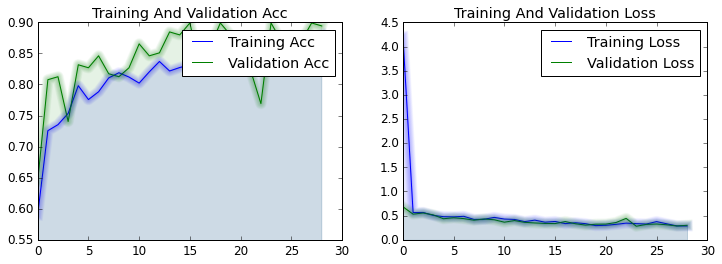

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.style.use('classic')
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Training And Validation Acc')
plt.legend()
mplcyberpunk.add_glow_effects()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training And Validation Loss')
plt.legend()
mplcyberpunk.add_glow_effects()
plt.show()

In [32]:
saved_model = tf.keras.models.load_model(
    SAVED_MODEL_PATH,
    custom_objects={'KerasLayer': hub.KerasLayer}
)

In [33]:
saved_model.evaluate(test_generator)

4/4 [==============================] - 6s 1s/step - loss: 0.2491 - accuracy: 0.9245


[0.24908201396465302, 0.9245283007621765]

In [35]:
svc = SVC(kernel='linear',gamma='auto')
svc.fit(train_generator)

TypeError: fit() missing 1 required positional argument: 'y'